# Identifying Need for Change: North Carolina School Performance

Out of the 2,617 public schools (including Charter) operating in North Carolina during the 2016-2017 school year, 902 schools (34.5%) have, for at least one year since 2013-2014, been classified as a low performing school. 

NCPDI classifies low performing schools as:

“Low-performing schools are those that receive a **school performance grade** of **D** or **F** and a **school growth score** of **"met expected growth"** or **"not met expected growth"** as defined by G.S. 115C-83.15.” (G.S. 115C-105.37(a)), and

“A Low-performing local school administrative unit is a unit in which the majority of the schools in that unit that received a school performance grade and school growth score as provided in G.S. 115C-83.15 have been identified as low-performing schools, as provided in G.S. 115C-105.37.” (G.S. 115C-105.39A(a)).

Source: http://www.ncpublicschools.org/schooltransformation/low-performing/

**Thus, we treat low performing schools as a proxy for aggregate student educational achievement.**


## Motivation: 
Of the 902 schools low performing between 2013/14 and 2016/17, 209 have been low performing for all schools years (8%), 203 have been low performing for 3 of the schools years (7.8%), 227 have been low performing for 2 schools years (8.7%), and 263 have been low performing once (10%). Another way to look at these numbers is to consider that out of the four school years between 2013/14 and 2016/2017, 24.4% of schools have been recurringly low performing. 

What does this mean in terms of students? 
Out of around the 1.5 million total number of students studying in a public school in the 2016/17 school year, around 460,000 of those students (30%) have had at least a year studying a low performing school. Around 100,000 students (6.8%) in North Carolina study at a school that has been low performing for 4 years. 


## Solution:
This notebook reviews NCPDI North Carolina School Report Card and Statistical Profile data to identify the factors that contribute to low school performance. 

We: 

1. Take a look at the heuristically most common reasons for low school performance: percentage of economically disadvantaged students, student demographics, and school funding to see if these indicators are statistically different in low performing schools. 

2. Identify which EOG and EOC assessments suffer the most for low performing schools. ie. Do all schools perform poorly on 3rd grade EOG reading assessments or are the assessment performances more random?

3. Remove the factors outside of the school adminsitration's control from the dataset to determine which school-level factors are most important in determining low performance by:
    1. Performing Feature Importance using XGBoost. XGBoost is a tree-based gradient-boosting method which minimizes a cost function relative to predicting a target variable. When a node in a decision tree is split, we can calculate the following reduction in impurity, and attribute this reduction to feature involved. When the tree is finished splitting nodes, those features with the largest proportional contribution toward decreasing impurity within nodes can be said to be the most “important.”
    2. Targeting schools that deviate between low performance and non-low performance. For each year, we isolate which schools either became low performing or non-low performing from the previous year. We rank the percent change in each feature, and deem those with the highest change of percentage year to year as potentially influential. 
    3. Finally, reviewing the covariance ranking of our selected features to determine which features likely interact in a parametric model. 
    
4. Test the predictive nature of our selected features by creating a classification model to predict whether or not a school is low performing for each of our 4 years. Whether these features are important will be reflected in the accuracy and precision of the classification model. 

5. Use a new methodology for decision-making. We create a function that will synthesize data based on percent changes in a certain input feature to then be used in our classification model to predict low performance. This will allow us to review, all things being equal, how a change in one or more features may correlate to a change in school performance. 


*Please note: Dataset Creation and Processing can be found: https://github.com/oleeson/NCPDI-Capstone*


# Narrowing of Focus and EDA

The end goal of our project is to identify school factors within administration's control that can be changed to improve the outcome of school performance. With initial exploratory data analysis we decide the following:

1. Remove Charter Schools from the dataset (operated privately)
2. To focus on Elementary and Middle Schools, as these schools are much more likely to be low performing. Improving student outcomes at the Elementary and Middle School level will also set up students for success in High School. 
3. Remove All Test Scores from the dataset, as these are perfect determinants of school performance 


## EDA for Motivation

In [1]:
#import required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

import seaborn as sns
sns.set(color_codes=True)

import warnings
warnings.filterwarnings("ignore")

cwd = os.getcwd()

In [2]:
#Change Dir to Import Dataset for EDA 
os.chdir("..")
cwd = os.getcwd()
cwd = cwd + "/DatasetCreation"

In [3]:
#Read in Dataset
#This dataset is all schools (including charter) in 2017
df_EDA = pd.read_csv(cwd+"/PublicSchools17_EDA.csv")

#### Total Impact

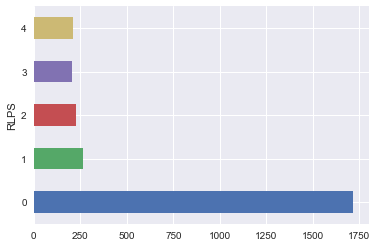

In [4]:
rlpsGroup = df_EDA.groupby(by='RLPS')
rlpsCount = rlpsGroup['RLPS'].count()
numbar17 = rlpsCount.plot(kind='barh')

In [5]:
schoolCount = len(df_EDA)

print("Number of Schools Low Performing...")
print('1 Year : ', rlpsCount[1], "(", round((rlpsCount[1]/schoolCount),3), ")")
print('2 Years: ', rlpsCount[2], "(", round((rlpsCount[2]/schoolCount),3), ")")
print('3 Years: ', rlpsCount[3], "(", round((rlpsCount[3]/schoolCount),3), ")")
print('4 Years: ', rlpsCount[4], "(", round((rlpsCount[4]/schoolCount),3), ")")
print('0 Years: ', rlpsCount[0], "(", round((rlpsCount[0]/schoolCount),3), ")")

print('****************************')
atLeastOnce = (rlpsCount[1] + rlpsCount[2] + rlpsCount[3] + rlpsCount[4])
print('Number of Schools at One Time Low Performing: ', atLeastOnce, "(", round(atLeastOnce/schoolCount,3), ")")

Number of Schools Low Performing...
1 Year :  263 ( 0.1 )
2 Years:  227 ( 0.087 )
3 Years:  203 ( 0.078 )
4 Years:  209 ( 0.08 )
0 Years:  1715 ( 0.655 )
****************************
Number of Schools at One Time Low Performing:  902 ( 0.345 )


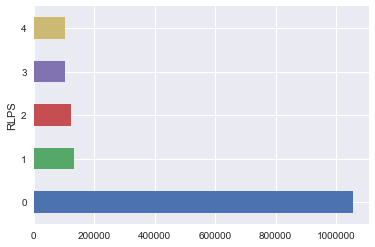

In [6]:
rlpsStud = rlpsGroup['student_num'].sum()
studbar17 = rlpsStud.plot(kind='barh')

In [7]:
studentCount = df_EDA['student_num'].sum()
print('Total Students: ', studentCount)

print('Number of Students in Schools Low Performing...')
print('1 Year : ', rlpsStud[1], "(", round((rlpsStud[1]/studentCount),3), ")")
print('2 Years: ', rlpsStud[2], "(", round((rlpsStud[2]/studentCount),3), ")")
print('3 Years: ', rlpsStud[3], "(", round((rlpsStud[3]/studentCount),3), ")")
print('4 Years: ', rlpsStud[4], "(", round((rlpsStud[4]/studentCount),3), ")")
print('0 Years: ', rlpsStud[0], "(", round((rlpsStud[0]/studentCount),3), ")")

print('****************************')
atLeastOnceStud = (rlpsStud[1] + rlpsStud[2] + rlpsStud[3] + rlpsStud[4])
print('Number of Schools at One Time Low Performing: ', atLeastOnceStud, "(", round(atLeastOnceStud/studentCount,3), ")")

Total Students:  1517530.0
Number of Students in Schools Low Performing...
1 Year :  132901.0 ( 0.088 )
2 Years:  124091.0 ( 0.082 )
3 Years:  101966.0 ( 0.067 )
4 Years:  103128.0 ( 0.068 )
0 Years:  1055444.0 ( 0.696 )
****************************
Number of Schools at One Time Low Performing:  462086.0 ( 0.304 )


#### Schools by Category
- E School has elementary schools grades (PK-5)
- M School has middle schools grades (6-8)
- H School has high schools grades (9-13)
- I School has elementary and middle school grades
- T School has middle and high school grades
- A School has elementary, middle, and high school grades

In [8]:
category = pd.crosstab([ df_EDA['category_cd'] ], 
                       df_EDA['RLPS'])

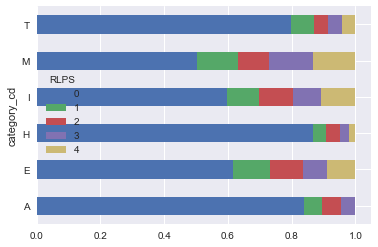

In [9]:
category_rate = category.div(category.sum(1).astype(float),
                             axis=0) # normalize the value

category_rate.plot(kind='barh', 
                   stacked=True)

In [10]:
print (category)

RLPS           0    1    2    3    4
category_cd                         
A             72    5    5    4    0
E            814  155  134  102  117
H            442   21   22   15   10
I             89   15   16   13   16
M            240   62   47   66   63
T             55    5    3    3    3


We see that Middle and Elementary Schools tend to have a higher proportion of total schools low performing.    

In [11]:
mSum = len(df_EDA[df_EDA['category_cd'] == 'M'])
eSum = len(df_EDA[df_EDA['category_cd'] == 'E'])
hSum = len(df_EDA[df_EDA['category_cd'] == 'H'])

mLow = (62+47+66+63)
eLow = (155+134+102+117)
hLow = (21+22+15+10)

print("Percentage of Middle Only Schools at one time Low Performing: ", round(mLow/mSum, 3))
print("Percentage of Elementary Only Schools at one time Low Performing: ", round(eLow/eSum, 3))
print("Percentage of High School Only Schools at one time Low Performing: ", round(hLow/hSum, 3))

Percentage of Middle Only Schools at one time Low Performing:  0.498
Percentage of Elementary Only Schools at one time Low Performing:  0.384
Percentage of High School Only Schools at one time Low Performing:  0.133


#### Look at Charter Schools before Removed

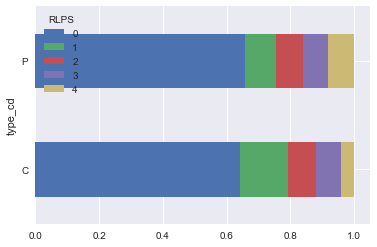

In [12]:
typeSchool = pd.crosstab([ df_EDA['type_cd'] ], 
                       df_EDA['RLPS'])
type_rate = typeSchool.div(typeSchool.sum(1).astype(float),
                             axis=0) # normalize the value

type_rate.plot(kind='barh', 
                   stacked=True)

In [13]:
print(typeSchool)

RLPS        0    1    2    3    4
type_cd                          
C         108   25   15   13    7
P        1607  238  212  190  202


There are 168 total charter schools. From the above bar chart it appears that the pattern of performance is similar to regular public schools. 

### Separate Data into Three Dataframes
Low Performing
Not Low Performing
Repeatedly Low Performing

In [14]:
lowPerform = df_EDA[df_EDA['RLPS']!=0]
print(lowPerform['unit_code'].count())

repeatLow = df_EDA[(df_EDA['RLPS'] == 2)|
                            (df_EDA['RLPS'] == 3)|
                            (df_EDA['RLPS'] == 4)]
print(repeatLow['unit_code'].count())

notLowPerform = df_EDA[df_EDA['RLPS'] == 0]
print(notLowPerform['unit_code'].count())

902
639
1715


In [17]:
## Create a new column that is boolean if low performing for visulization plots
LowP_series = []
for index, row in df_EDA.iterrows():
    if row['RLPS'] == 0:
        LowP_series.append('NotLowPerforming')
    else: 
        LowP_series.append('LowPerforming')
print(np.unique(LowP_series))
df_EDA['LPSBool'] = LowP_series

['LowPerforming' 'NotLowPerforming']


## Percent Economically Disadvantaged
Have this just need to move it over

In [20]:
# Averages across performance types
# NOT LOW PERFORMING
nlpEDSAverages = {}
nlpEDS = notLowPerform['pct_eds'].mean()
nlpEDSAverages['EDS'] = nlpEDS
print("Not Low Performing : ")
print(nlpEDSAverages)
print('Percentage No Data: ', notLowPerform['pct_eds'].isnull().T.sum()/notLowPerform['unit_code'].count())

# LOW PERFORMING
lowPEDSAverages = {}
lowPEDS = lowPerform['pct_eds'].mean()
lowPEDSAverages['EDS'] = lowPEDS
print('\n', "Low Performing : ")
print(lowPEDSAverages)
print('Percentage No Data: ', lowPerform['pct_eds'].isnull().T.sum()/lowPerform['unit_code'].count())


# REPEAT LOW PERFORMING 
repLowPEDSAverages = {}
repLowPEDS = repeatLow['pct_eds'].mean()
repLowPEDSAverages['EDS'] = repLowPEDS
print('\n', "Repeatedly Low Performing : ")
print(repLowPEDSAverages)
print('Percentage No Data: ', repeatLow['pct_eds'].isnull().T.sum()/repeatLow['unit_code'].count())

Not Low Performing : 
{'EDS': 45.690962099125365}
Percentage No Data:  0.0

 Low Performing : 
{'EDS': 67.080598669623058}
Percentage No Data:  0.0

 Repeatedly Low Performing : 
{'EDS': 69.297652582159614}
Percentage No Data:  0.0


In [16]:
EDSAvg = pd.DataFrame(data=[nlpEDSAverages, lowPEDSAverages, repLowPEDSAverages], 
                      index=['NotLowPerform', 'LowPerform', 'RepLowPerform'])
EDSAvg = EDSAvg.T
EDSAvg

,NotLowPerform,LowPerform,RepLowPerform
EDS,45.690962,67.080599,69.297653


### Test significance of differences in means using Welch's T-Test

In [18]:
from scipy.stats import ttest_ind

cat1 = df_EDA[df_EDA['LPSBool']=='NotLowPerforming']
cat2 = df_EDA[df_EDA['LPSBool']=='LowPerforming']

ttest_ind(cat1['pct_eds'], cat2['pct_eds'], equal_var=False)

Ttest_indResult(statistic=-31.263342114784276, pvalue=1.8394119544783132e-179)

We find that the difference in means of percentage of students that are economically disadvantaged between low performing and repeatedly low performing schools is statistically siginificant. P-value <0.0001

Text(0.5,1,'Probability Distribution Function of Economically Disadvantaged Students')

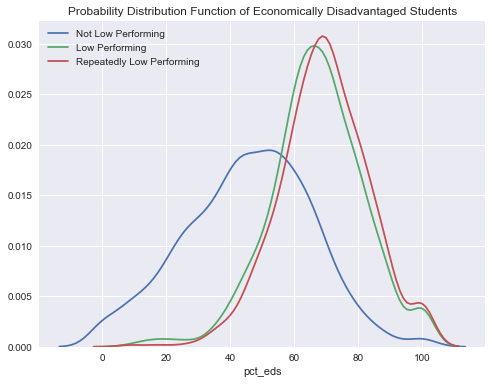

In [23]:
f, ax = plt.subplots(figsize=(8,6))
a = sns.distplot(notLowPerform['pct_eds'].dropna(),
             hist=False,
             label = 'Not Low Performing')
b = sns.distplot(lowPerform['pct_eds'].dropna(),
             hist=False,
             label = 'Low Performing')
c = sns.distplot(repeatLow['pct_eds'].dropna(),
             hist=False,
             label = 'Repeatedly Low Performing')
plt.title('Probability Distribution Function of Economically Disadvantaged Students')

## Racial Demographics

In [24]:
# Averages across performance types
# NOT LOW PERFORMING
nlpAverages = {}
nlpWhite = notLowPerform['WhitePct'].mean()
nlpAverages['White'] = nlpWhite
nlpBlack = notLowPerform['BlackPct'].mean()
nlpAverages['Black'] = nlpBlack
nlpHispanic = notLowPerform['HispanicPct'].mean()
nlpAverages['Hispanic'] = nlpHispanic
nlpAsian = notLowPerform['AsianPct'].mean()
nlpAverages['Asian'] = nlpAsian
nlpIndian = notLowPerform['IndianPct'].mean()
nlpAverages['Indian'] = nlpIndian
nlpPacific = notLowPerform['PacificIslandPct'].mean()
nlpAverages['PacificIsl'] = nlpPacific
nlpTwo = notLowPerform['TwoOrMorePct'].mean()
nlpAverages['TwoPlus'] = nlpTwo
print('\n', "Not Low Performing : ")
print(nlpAverages)

# LOW PERFORMING

lowPAverages = {}
lowPWhite = lowPerform['WhitePct'].mean()
lowPAverages['White'] = lowPWhite
lowPBlack = lowPerform['BlackPct'].mean()
lowPAverages['Black'] = lowPBlack
lowPHispanic = lowPerform['HispanicPct'].mean()
lowPAverages['Hispanic'] = lowPHispanic
lowPAsian = lowPerform['AsianPct'].mean()
lowPAverages['Asian'] = lowPAsian
lowPIndian = lowPerform['IndianPct'].mean()
lowPAverages['Indian'] = lowPIndian
lowPPacific = lowPerform['PacificIslandPct'].mean()
lowPAverages['PacificIsl'] = lowPPacific
lowPTwo = lowPerform['TwoOrMorePct'].mean()
lowPAverages['TwoPlus'] = lowPTwo
print('\n', "Low Performing : ")
print(lowPAverages)

# REPEAT LOW PERFORMING 

repLowPAverages = {}
repLowPWhite = repeatLow['WhitePct'].mean()
repLowPAverages['White'] = repLowPWhite
repLowPBlack = repeatLow['BlackPct'].mean()
repLowPAverages['Black'] = repLowPBlack
repLowPHispanic = repeatLow['HispanicPct'].mean()
repLowPAverages['Hispanic'] = repLowPHispanic
repLowPAsian = repeatLow['AsianPct'].mean()
repLowPAverages['Asian'] = repLowPAsian
repLowPIndian = repeatLow['IndianPct'].mean()
repLowPAverages['Indian'] = repLowPIndian
repLowPPacific = repeatLow['PacificIslandPct'].mean()
repLowPAverages['PacificIsl'] = repLowPPacific
repLowPTwo = repeatLow['TwoOrMorePct'].mean()
repLowPAverages['TwoPlus'] = repLowPTwo
print('\n', "Repeatedly Low Performing : ")
print(repLowPAverages)


 Not Low Performing : 
{'White': 0.58620329049682751, 'Black': 0.19120991312147984, 'Hispanic': 0.14235224068611094, 'Asian': 0.029774555097860231, 'Indian': 0.0083160696535381062, 'PacificIsl': 0.0011863131537084889, 'TwoPlus': 0.040957617790474819}

 Low Performing : 
{'White': 0.29545705569286035, 'Black': 0.4062003242830089, 'Hispanic': 0.21610064155742995, 'Asian': 0.016333263993736732, 'Indian': 0.02429871654618742, 'PacificIsl': 0.0014891774038242468, 'TwoPlus': 0.04012082052295244}

 Repeatedly Low Performing : 
{'White': 0.24246484931447213, 'Black': 0.44863640820222012, 'Hispanic': 0.2257245763816694, 'Asian': 0.015693881431521603, 'Indian': 0.027936824987482206, 'PacificIsl': 0.0015680162949614819, 'TwoPlus': 0.037975443387673148}


In [25]:
raceAvg = pd.DataFrame(data=[nlpAverages, lowPAverages, repLowPAverages], 
                      index=['NotLowPerform', 'LowPerform', 'RepLowPerform'])
raceAvg = raceAvg.T
raceAvg

,NotLowPerform,LowPerform,RepLowPerform
Asian,0.029775,0.016333,0.015694
Black,0.191210,0.406200,0.448636
Hispanic,0.142352,0.216101,0.225725
Indian,0.008316,0.024299,0.027937
PacificIsl,0.001186,0.001489,0.001568
TwoPlus,0.040958,0.040121,0.037975
White,0.586203,0.295457,0.242465


Text(0.5,1,'Probability Distribution of Percentage White Students')

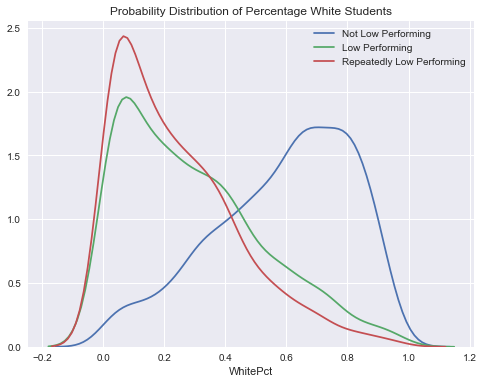

In [26]:
f, ax = plt.subplots(figsize=(8,6))
a = sns.distplot(notLowPerform['WhitePct'].dropna(),
             hist=False,
             label = 'Not Low Performing')
b = sns.distplot(lowPerform['WhitePct'].dropna(),
             hist=False,
             label = 'Low Performing')
c = sns.distplot(repeatLow['WhitePct'].dropna(),
             hist=False,
             label = 'Repeatedly Low Performing')
#ax.set(xlim=(0,1))
plt.title('Probability Distribution of Percentage White Students')


## Funding
We do not have school-level funding data for most of our schools. This makes it difficult to see how much individual funding per pupil each school receives. The schools for which this data exists are all **charter** schools.

In [28]:
print ('Percentage of schools without school level federal funding data: ')
print((df_EDA['federal_perpupil_num'].isna().sum())/(df_EDA['federal_perpupil_num'].isna().count()))

print ('Percentage of schools without school level state funding data: ')
print((df_EDA['state_perpupil_num'].isna().sum())/(df_EDA['state_perpupil_num'].isna().count()))

print ('Percentage of schools without school level local funding data: ')
print((df_EDA['local_perpupil_num'].isna().sum())/(df_EDA['local_perpupil_num'].isna().count()))


Percentage of schools without school level federal funding data: 
0.935804356133
Percentage of schools without school level state funding data: 
0.935804356133
Percentage of schools without school level local funding data: 
0.935804356133


Text(0.5,1,'Histogram of Local Funding at the LEA level')

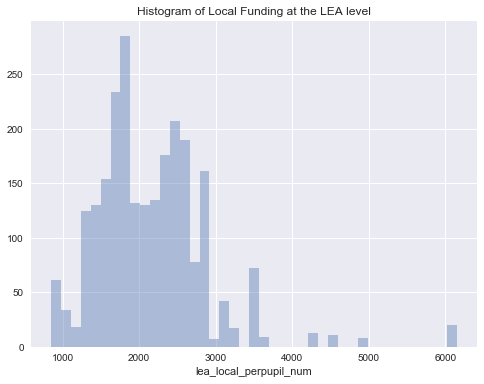

In [32]:
f, ax = plt.subplots(figsize=(8,6))
a = sns.distplot(df_EDA['lea_local_perpupil_num'].dropna(),
             hist=True,
                kde = False)
plt.title('Histogram of Local Funding at the LEA level')

In [33]:
# Averages across performance types
# NOT LOW PERFORMING
nlpFundAverages = {}
nlpLocal = notLowPerform['lea_local_perpupil_num'].mean()
nlpFundAverages['LEA_Local_Funding'] = nlpLocal
nlpState= notLowPerform['lea_state_perpupil_num'].mean()
nlpFundAverages['LEA_State_Funding'] = nlpState
nlpFed = notLowPerform['lea_federal_perpupil_num'].mean()
nlpFundAverages['LEA_Fed_Funding'] = nlpFed
print('\n', "Not Low Performing : ")
print(nlpFundAverages)

# LOW PERFORMING
lowPFundAverages = {}
lowpLocal = lowPerform['lea_local_perpupil_num'].mean()
lowPFundAverages['LEA_Local_Funding'] = lowpLocal
lowpState= lowPerform['lea_state_perpupil_num'].mean()
lowPFundAverages['LEA_State_Funding'] = lowpState
lowpFed = lowPerform['lea_federal_perpupil_num'].mean()
lowPFundAverages['LEA_Fed_Funding'] = lowpFed
print('\n', "Low Performing : ")
print(lowPFundAverages)


# REPEAT LOW PERFORMING 
repLowPFundAverages = {}
repLowPLocal = repeatLow['lea_local_perpupil_num'].mean()
repLowPFundAverages['LEA_Local_Funding'] = repLowPLocal
repLowPState= repeatLow['lea_state_perpupil_num'].mean()
repLowPFundAverages['LEA_State_Funding'] = repLowPState
repLowPFed = repeatLow['lea_federal_perpupil_num'].mean()
repLowPFundAverages['LEA_Fed_Funding'] = repLowPFed
print('\n', "Repeatedly Low Performing : ")
print(repLowPFundAverages)


 Not Low Performing : 
{'LEA_Local_Funding': 2221.1741132545112, 'LEA_State_Funding': 6054.8454138145598, 'LEA_Fed_Funding': 1015.3209769757312}

 Low Performing : 
{'LEA_Local_Funding': 2015.1272921615205, 'LEA_State_Funding': 6225.1573040380035, 'LEA_Fed_Funding': 1183.9848218527316}

 Repeatedly Low Performing : 
{'LEA_Local_Funding': 2012.8818543046359, 'LEA_State_Funding': 6261.3997516556292, 'LEA_Fed_Funding': 1214.8034437086092}


In [34]:
FundAvg = pd.DataFrame(data=[nlpFundAverages, lowPFundAverages, repLowPFundAverages], 
                      index=['NotLowPerform', 'LowPerform', 'RepLowPerform'])
FundAvg = FundAvg.T
FundAvg

,NotLowPerform,LowPerform,RepLowPerform
LEA_Fed_Funding,1015.320977,1183.984822,1214.803444
LEA_Local_Funding,2221.174113,2015.127292,2012.881854
LEA_State_Funding,6054.845414,6225.157304,6261.399752


We see that repeatedly low performing schools receive more State and Federal funding than non-low performing schools. This is consistent with the way in which funding is allocated. Schools that meet certain disadvantage criteria are eligible for more state and federal programs for supplemental funding.

## Take a look at charter schools

We now take a look at charter schools, for which we have the school-level funding data for. We have 168 charter schools in our dataset.

In [48]:
df_Charter = df_EDA[df_EDA['type_cd'] == 'C']
print('Number of Charters: ', len(df_Charter))

print('Low Performing: ', len(lowPerform[lowPerform['type_cd'] == 'C'] ))
print('Repeatedly Low Performing: ', len(repeatLow[repeatLow['type_cd'] == 'C']))
print('Not Low Performing: ', len(notLowPerform[notLowPerform['type_cd'] == 'C']))

Number of Charters:  168
Low Performing:  60
Repeatedly Low Performing:  35
Not Low Performing:  108


In [43]:
# Averages across performance types
# NOT LOW PERFORMING
nlpFundAverages = {}
nlpLocal = notLowPerform['local_perpupil_num'].mean()
nlpFundAverages['Local_Funding'] = nlpLocal
nlpState= notLowPerform['state_perpupil_num'].mean()
nlpFundAverages['State_Funding'] = nlpState
nlpFed = notLowPerform['federal_perpupil_num'].mean()
nlpFundAverages['Fed_Funding'] = nlpFed
print('\n', "Not Low Performing : ")
print(nlpFundAverages)

# LOW PERFORMING
lowPFundAverages = {}
lowpLocal = lowPerform['local_perpupil_num'].mean()
lowPFundAverages['Local_Funding'] = lowpLocal
lowpState= lowPerform['state_perpupil_num'].mean()
lowPFundAverages['State_Funding'] = lowpState
lowpFed = lowPerform['federal_perpupil_num'].mean()
lowPFundAverages['Fed_Funding'] = lowpFed
print('\n', "Low Performing : ")
print(lowPFundAverages)


# REPEAT LOW PERFORMING 
repLowPFundAverages = {}
repLowPLocal = repeatLow['local_perpupil_num'].mean()
repLowPFundAverages['Local_Funding'] = repLowPLocal
repLowPState= repeatLow['state_perpupil_num'].mean()
repLowPFundAverages['State_Funding'] = repLowPState
repLowPFed = repeatLow['federal_perpupil_num'].mean()
repLowPFundAverages['Fed_Funding'] = repLowPFed
print('\n', "Repeatedly Low Performing : ")
print(repLowPFundAverages)



 Not Low Performing : 
{'Local_Funding': 3152.8578703703706, 'State_Funding': 5803.4484259259252, 'Fed_Funding': 238.64537037037039}

 Low Performing : 
{'Local_Funding': 3258.1881666666673, 'State_Funding': 6129.0426666666672, 'Fed_Funding': 616.94083333333333}

 Repeatedly Low Performing : 
{'Local_Funding': 2586.7837142857147, 'State_Funding': 6172.3788571428568, 'Fed_Funding': 739.04228571428575}


In [44]:
FundAvg = pd.DataFrame(data=[nlpFundAverages, lowPFundAverages, repLowPFundAverages], 
                      index=['NotLowPerform', 'LowPerform', 'RepLowPerform'])
FundAvg = FundAvg.T
FundAvg

,NotLowPerform,LowPerform,RepLowPerform
Fed_Funding,238.645370,616.940833,739.042286
Local_Funding,3152.857870,3258.188167,2586.783714
State_Funding,5803.448426,6129.042667,6172.378857


Repeatedly low performing charters receive more state and federal funding that non-low performing charters. It is important to not that the local funding for charters is significantly less for repeatedly low performing schools than for low performing and non-low performing schools. This could provide some evidence that local funding is important at the school-level. 

## Remove Charters and only Include Middle/Elementary Schools in Datasets
The datasets read in with suffix LPS_Processed already do not include charter schools.

In [14]:
## Middle Schools
df_mid_14 = pd.read_csv(cwd+'/2014/PublicMiddleSchools2014_LPS_Processed.csv')
df_mid_14 = pd.read_csv(cwd+'/2014/PublicMiddleSchools2014_LPS_Processed.csv')
df_mid_15 = pd.read_csv(cwd+'/2015/PublicMiddleSchools2015_LPS_Processed.csv')
df_mid_16 = pd.read_csv(cwd+'/2016/PublicMiddleSchools2016_LPS_Processed.csv')
df_mid_17 = pd.read_csv(cwd+'/2017/PublicMiddleSchools2017_LPS_Processed.csv')

## Elementary Schools
df_elem_14 = pd.read_csv(cwd+'/2014/PublicElementarySchools2014_LPS_Processed.csv')
df_elem_15 = pd.read_csv(cwd+'/2015/PublicElementarySchools2015_LPS_Processed.csv')
df_elem_16 = pd.read_csv(cwd+'/2016/PublicElementarySchools2016_LPS_Processed.csv')
df_elem_17 = pd.read_csv(cwd+'/2017/PublicElementarySchools2017_LPS_Processed.csv')

In [15]:
## Column Names
import pickle
cwd = cwd + '/'

fileObject = open(cwd +'2017/TableColumns/ec_pupils_pct_Cols_17.pkl', 'rb')
ec_pupils_pct_Cols_17 = pickle.load(fileObject)

fileObject = open(cwd +'2017/TableColumns/edRatesCols_17.pkl', 'rb')
edRatesCols_17 = pickle.load(fileObject)

fileObject = open(cwd+'2017/TableColumns/effectivenessCols_17.pkl', 'rb')
effectivenessCols_17 = pickle.load(fileObject)

fileObject = open(cwd+'2017/TableColumns/environmentCols_17.pkl', 'rb')
environmentCols_17 = pickle.load(fileObject)

fileObject = open(cwd+'2017/TableColumns/fundingCols_17.pkl', 'rb')
fundingCols_17 = pickle.load(fileObject)

fileObject = open(cwd+'2017/TableColumns/personnelCols_17.pkl', 'rb')
personnelCols_17 = pickle.load(fileObject)

fileObject = open(cwd+'2017/TableColumns/profileCols_17.pkl', 'rb')
profileCols_17 = pickle.load(fileObject)

fileObject = open(cwd+'2017/TableColumns/profileMetricCols_17.pkl', 'rb')
profileMetricCols_17 = pickle.load(fileObject)

fileObject = open(cwd+'2017/TableColumns/pTargets_17.pkl', 'rb')
pTargets_17 = pickle.load(fileObject)

fileObject = open(cwd+'2017/TableColumns/readinessCols_17.pkl', 'rb')
readinessCols_17 = pickle.load(fileObject)

fileObject = open(cwd+'2017/TableColumns/sceCols_17.pkl', 'rb')
sceCols_17 = pickle.load(fileObject)

fileObject = open(cwd+'2017/TableColumns/sceCols_17.pkl', 'rb')
sceCols_17 = pickle.load(fileObject)

fileObject = open(cwd+'2017/TableColumns/spgCols_17.pkl', 'rb')
spgCols_17 = pickle.load(fileObject)

fileObject = open(cwd+'2017/TableColumns/yoeCols_17.pkl', 'rb')
yoeCols_17 = pickle.load(fileObject)

In [16]:
# Changing to LPS so it works with the xgboost functions
df_elem_17 = df_elem_17.rename(columns = {'LPS_17' : 'LPS'})
df_mid_17 = df_mid_17.rename(columns = {'LPS_17' : 'LPS'})

# Full list of columns, including Personnel, Environment, and Teacher Experience Variables
combined_cols = (environmentCols_17 + list(set(personnelCols_17) - set(environmentCols_17)))
yoeCols_17 = ['0-3 Years_Exp_Pct_Tch',
            '10+ Years_Exp_Pct_Tch',
            '4-10 Years_Exp_Pct_Tch',
            '0-3 Years_LEA_Exp_Pct_Prin',
            '10+ Years_LEA_Exp_Pct_Prin',
            '4-10 Years_LEA_Exp_Pct_Prin']
for col in yoeCols_17:
    combined_cols.append(col)
combined_cols.append('LPS')

In [17]:
# Subsets each dataframe based on the columns it shares with the 
# three sets of variables found in "combined_cols" (environment, personnel, and yoe)
df_elem_14 = df_elem_14[df_elem_14.columns.intersection(combined_cols)]
df_mid_14 = df_mid_14[df_mid_14.columns.intersection(combined_cols)]
df_elem_15 = df_elem_15[df_elem_15.columns.intersection(combined_cols)]
df_mid_15 = df_mid_15[df_mid_15.columns.intersection(combined_cols)]
df_elem_16 = df_elem_16[df_elem_16.columns.intersection(combined_cols)]
df_mid_16 = df_mid_16[df_mid_16.columns.intersection(combined_cols)]
df_elem_17 = df_elem_17[df_elem_17.columns.intersection(combined_cols)]
df_mid_17 = df_mid_17[df_mid_17.columns.intersection(combined_cols)]

# Storing dfs in list for later iteration
all_datasets = [df_elem_14, df_mid_14,
                df_elem_15, df_mid_15,
                df_elem_16, df_mid_16,
                df_elem_17, df_mid_17]

# Feature Importance Using XGBoost

Data Tables: 
- ec_pupils_pct : Racial Demographics
- edRates : Economically Disadvantaged
- effectiveness: Educator Effectiveness
- environment: Environment
- funding: Funding
- personnel: Personnel
- pTargets : Participation Targets
- Readiness : Readiness
- sce : Specialized Course Enrollment
- schoolInds : School Indicators
- spg : School Performance
- yoe : Years of Experience

http://www.ncpublicschools.org/docs/src/researchers/data-dictionary.pdf

In [18]:
from sklearn import preprocessing
from xgboost import XGBClassifier
from xgboost import plot_importance
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [19]:
def xg_booster_seat(df, varset='all'):
    '''Performs xgboost on given set of variables, 
        returns feature importances'''
    
    # Subsetting variables if necessary
    if varset == 'all':
        df = df
    else:
        df = df[df.columns.intersection(varset)]
    
    # Predicting LPS
    y = df['LPS']
    x = df.drop('LPS', axis=1)
        
    # Fitting the model
    model = XGBClassifier(nthread=4)
    model.fit(x, y)
   
    # Storing feature importances in dataframe
    feat_importances = pd.DataFrame(model.feature_importances_, index=x.columns)
    
    return feat_importances

col_names = ["df_elem_14_featimp", "df_mid_14_featimp", 
            "df_elem_15_featimp", "df_mid_15_featimp", 
            "df_elem_16_featimp", "df_mid_16_featimp", 
            "df_elem_17_featimp", "df_mid_17_featimp"]

def get_importances(col_names=col_names, varset='all'):
    
    importances = pd.DataFrame()
    for df in all_datasets:
        temp = xg_booster_seat(df, varset=varset)
        importances = pd.concat([importances, temp], axis=1)
    
    importances.columns = col_names
    importances['mean'] = importances.mean(axis=1)
    importances['std'] = importances.std(axis=1)
    
    return importances

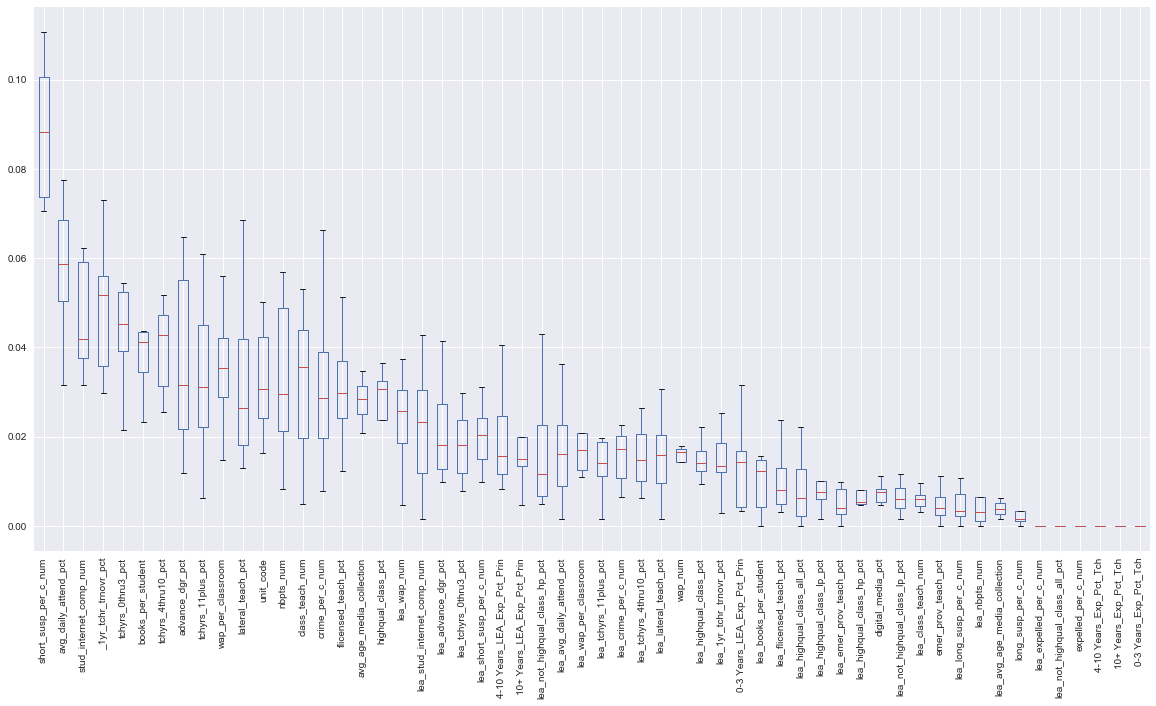

In [20]:
%matplotlib inline
all_importances = get_importances()
all_importances_plots = all_importances.sort_values('mean', ascending=False).T.drop(['mean','std'], axis=0)
all_importances_plots.boxplot(figsize=(20,10), rot=90)

### Environment Variables Only


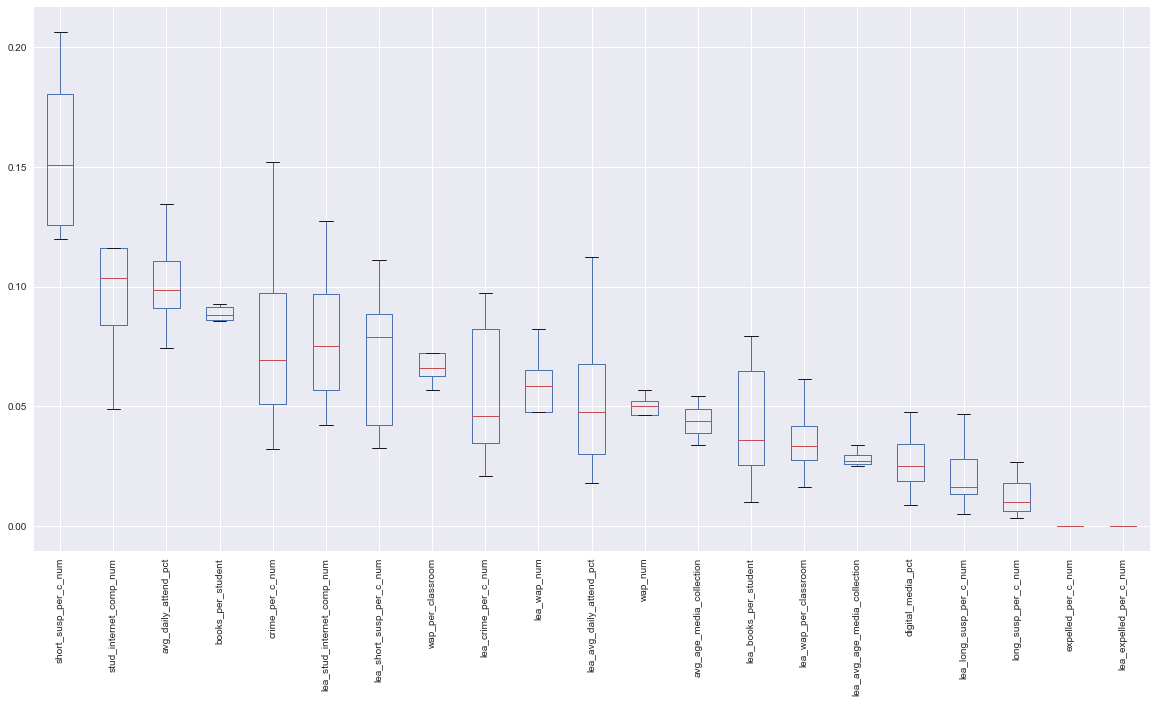

In [21]:
environmentCols_17.append("LPS")
environmentCols_17.remove("unit_code")
environment_importances = get_importances(varset=environmentCols_17)
environment_importances_plots = environment_importances.sort_values('mean', ascending=False).T.drop(['mean','std'], axis=0)
environment_importances_plots.boxplot(figsize=(20,10), rot=90)